#### 模型部署步骤

先使用mmdeploy将训练好的模型转换为onnx格式

可以直接安装mmdeploy进行推理，即使想要直接用onnx库，也需要先用mmdeploy做测试，看看onnx模型能否成功跑通

跑通后如果需要直接使用onnx库，则需要自己写好预处理方法，然后调用onnx库进行推理

#### pth模型转换为onnx

有两种转换方式，一种是使用python代码转换，还有一种是通过命令行转换

In [ ]:
import onnxruntime
import cv2
import numpy as np

from mmdeploy.apis import torch2onnx

# 关键参数配置
img_path = paths
work_dir = rf'H:\临时使用数据'
save_file = 'model.onnx'
deploy_cfg = rf'E:\code\openmmlab\mmdeploy\configs\mmseg\segmentation_onnxruntime_dynamic.py'
model_cfg = rf'H:\临时使用数据\config.py'  # 您的模型配置文件
checkpoint = rf'H:\临时使用数据\deeplabv3plus_20250620_113954.pth'  # 训练好的权重

# 执行转换
torch2onnx(img_path, work_dir, save_file, deploy_cfg, model_cfg, checkpoint, device='cpu')

#### MMseg推理

先确认原本的pth模型是没有问题的

In [9]:
import os
from argparse import ArgumentParser
from mmengine.model import revert_sync_batchnorm
from mmseg.apis import inference_model, init_model, show_result_pyplot 
import numpy as np
import cv2
from tqdm import tqdm

# device = 'cpu'  # cpu or 'cuda:0'


class MMSegDetector:
    def __init__(self, config_path, checkpoint_path, device):
        self.device = device
        self.model = init_model(config_path, checkpoint_path, device=device)
        if device == 'cpu':
            self.model = revert_sync_batchnorm(self.model)

    def infer(self, img_path):
        result = inference_model(self.model, img_path)
        if self.device == 'cpu':
            pred_mask = result.pred_sem_seg.data[0].numpy().astype(np.uint8)
        else:
            pred_mask = result.pred_sem_seg.data[0].cpu().numpy().astype(np.uint8)
        return pred_mask

    def visual(self, pred_mask, image):

        colored_mask = np.zeros_like(image)
        colored_mask[pred_mask == 1] = [0, 0, 255]
        alpha = 0.5
        vis_img = image.copy()
        vis_img[pred_mask == 1] = cv2.addWeighted(image[pred_mask == 1], 1 - alpha, colored_mask[pred_mask == 1], alpha,
                                                  0)

        return vis_img

import os

def find_files_with_extension(start_path, extension):
    file_list = []

    # 遍历起始路径下的所有文件和文件夹
    for root, dirs, files in os.walk(start_path):
        for file in files:
            # 检查文件后缀是否匹配
            if file.endswith(extension):
                # 构建完整的文件路径并添加到列表中
                file_path = os.path.join(root, file)
                file_list.append(file_path)

    return file_list




e:\code\openmmlab\mmsegmentation\mmseg\models\decode_heads\decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
e:\code\openmmlab\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: H:\临时使用数据\deeplabv3plus_20250620_113954.pth


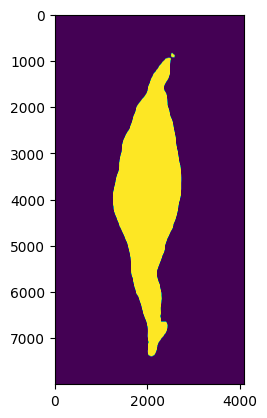

In [10]:

config_path = rf'H:\临时使用数据\config.py'
checkpoint_path = rf"H:\临时使用数据\deeplabv3plus_20250620_113954.pth"
device = 'cpu'  # cpu or 'cuda:0'
# init_default_scope("mmseg")
seg_detector = MMSegDetector(
    config_path=config_path,
    checkpoint_path=checkpoint_path,
    device=device)


import glob
paths = rf'H:\临时使用数据\标注数据\2.bmp'

cv_img = cv2.imdecode(np.fromfile( paths, dtype=np.uint8), 1)
pred_mask = seg_detector.infer(cv_img)
    # if pred_mask.max() == 0:
    #     continue
    # vis_img = seg_detector.visual(pred_mask, cv_img)
    # savepath = imgpath.replace('.png', '可视化.png')
    # cv2.imencode(".png", vis_img)[1].tofile(savepath)
    # print(savepath)
import matplotlib.pyplot as plt
plt.imshow(pred_mask)

#### 使用mmdeploy进行推理

可以在目标环境直接按照mmdeploy，但是如果需要只使用onnx库，也需要先检验一下onnx是没有问题的

06/27 11:00:37 - mmengine - INFO - Successfully loaded onnxruntime custom ops from d:\Anaconda\envs\mmdete\lib\site-packages\mmdeploy\lib\mmdeploy_onnxruntime_ops.dll


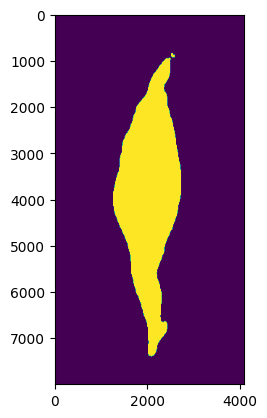

In [4]:
from mmdeploy.apis.utils import build_task_processor
from mmdeploy.utils import get_input_shape, load_config
import torch
import matplotlib.pyplot as plt
import numpy as np

deploy_cfg = rf'E:\code\openmmlab\mmdeploy\configs\mmseg\segmentation_onnxruntime_dynamic.py'
model_cfg = rf'H:\临时使用数据\config.py'
device = 'cpu'
backend_model = ['E:\code\openmmlab\mmdeploy\output/end2end.onnx']
image = rf'H:\临时使用数据\标注数据\2.bmp'

# read deploy_cfg and model_cfg
deploy_cfg, model_cfg = load_config(deploy_cfg, model_cfg)

# build task and backend model
task_processor = build_task_processor(model_cfg, deploy_cfg, device)
model = task_processor.build_backend_model(backend_model)

# process input image
input_shape = get_input_shape(deploy_cfg)
model_inputs, _ = task_processor.create_input(image, input_shape)

# do model inference
with torch.no_grad():
    result = model.test_step(model_inputs)

# visualize results
task_processor.visualize(
    image=image,
    model=model,
    result=result[0],
    window_name='visualize',
    output_file='./output_segmentation.png')

plt.imshow(np.array(result[0].pred_sem_seg.data[0,:,:]))

### onnx推理

需要自己把原本训练模型所使用的预处理方式和后处理方式搬出来

因为onnx文件只包含后端推理

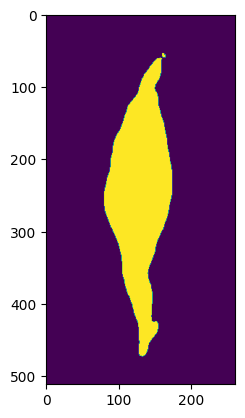

In [19]:
import onnxruntime as ort
import cv2
import numpy as np
import matplotlib.pyplot as plt

class ONNXSegmentationInference:
    def __init__(self, onnx_path, img_size=(512, 512)):
        # 初始化ONNX推理器
        self.session = ort.InferenceSession(onnx_path)
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name
        self.img_size = img_size
        self.mean = np.array([123.675, 116.28, 103.53], dtype=np.float32)
        self.std = np.array([58.395, 57.12, 57.375], dtype=np.float32)


    def preprocess(self, image):
        # 图像预处理
        orig_h, orig_w = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB
        scale = min(self.img_size[0] / orig_h, self.img_size[1] / orig_w)
        new_h, new_w = int(orig_h * scale), int(orig_w * scale)
        
        resized_img = cv2.resize(image, (new_w, new_h))
        normalized_img = (resized_img - self.mean) / self.std
        transposed_img = normalized_img.transpose(2, 0, 1)
        processed_img = np.expand_dims(transposed_img, axis=0).astype(np.float32)
        return processed_img, (orig_h, orig_w), (new_h, new_w)



    def inference(self, image):
        # 执行推理
        input_tensor, orig_size, new_size = self.preprocess(image)
        output = self.session.run([self.output_name], {self.input_name: input_tensor})[0]
        return output

    def postprocess(self, output, orig_size, new_size):
        # 后处理: 从ONNX输出得到掩码
        pred = output[0].argmax(axis=0).astype(np.uint8)
        cropped = pred[:new_size[0], :new_size[1]]
        final_mask = cv2.resize(cropped, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)
        # 输出final_mask
        plt.imshow(final_mask)
        plt.show

        return final_mask

    def visualize(self, image, mask):
        # 可视化分割结果
        color_mask = np.zeros_like(image)
        color_mask[mask == 1] = [0, 255, 0]  # 将类别1标记为绿色
        vis_img = cv2.addWeighted(image, 1, color_mask, 0.5, 0)
        return vis_img



# 初始化推理器
onnx_path = rf'E:\code\openmmlab\mmdeploy\output/end2end.onnx'  # 替换为你的ONNX模型路径
inferencer = ONNXSegmentationInference(onnx_path)

# 执行推理
raw_output = inferencer.inference(cv_img)

plt.imshow(raw_output[0,0,:,:])
plt.show()